In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, mannwhitneyu
from statsmodels.stats.multitest import multipletests

Firstly, we can take a look at a single result file.

In [5]:
df = pd.read_csv('polya_results_new_gam_pass.tsv', sep='\t', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,ee53ed33-3583-4298-8253-208a6c327886,Chr01,12054,2.0,3.0,6477.0,8368.0,103.86,60.17,PASS
1,681c7970-e97e-4012-bc06-f030d67bb01a,Chr01,8973,3.0,4.0,6106.0,7895.0,115.85,63.77,PASS
2,8a20b20d-35db-4c2c-9a77-a82b3584a9f5,Chr01,17046,2.0,3.0,3227.0,4394.0,115.85,39.85,PASS
3,f40a7587-5571-4374-9a71-ae16be9afff2,Chr01,17077,265.0,518.0,4802.0,6675.0,120.48,69.88,PASS
4,b3aab1e9-b31b-482b-ab2a-5c13222776d0,Chr01,17062,2.0,3.0,4761.0,7226.0,97.16,74.48,PASS


Adding column names.

In [6]:
df = df.rename(columns={0: "readname",  1: "contig", 2:  "position", 3: "leader_start",  4: "adapter_start",  5: "polya_start", 6: "transcript_start", 7: "read_rate", 8: "polya_length", 9: "qc_tag"})
df = df.drop(columns="qc_tag" )
df.head()

,readname,contig,position,leader_start,adapter_start,polya_start,transcript_start,read_rate,polya_length
0,ee53ed33-3583-4298-8253-208a6c327886,Chr01,12054,2.0,3.0,6477.0,8368.0,103.86,60.17
1,681c7970-e97e-4012-bc06-f030d67bb01a,Chr01,8973,3.0,4.0,6106.0,7895.0,115.85,63.77
2,8a20b20d-35db-4c2c-9a77-a82b3584a9f5,Chr01,17046,2.0,3.0,3227.0,4394.0,115.85,39.85
3,f40a7587-5571-4374-9a71-ae16be9afff2,Chr01,17077,265.0,518.0,4802.0,6675.0,120.48,69.88
4,b3aab1e9-b31b-482b-ab2a-5c13222776d0,Chr01,17062,2.0,3.0,4761.0,7226.0,97.16,74.48


In [7]:
df.polya_length.describe()

count    660541.000000
mean         73.776493
std          43.943293
min           0.000000
25%          41.150000
50%          64.000000
75%          96.190000
max         686.850000
Name: polya_length, dtype: float64

What length is in different genes? 

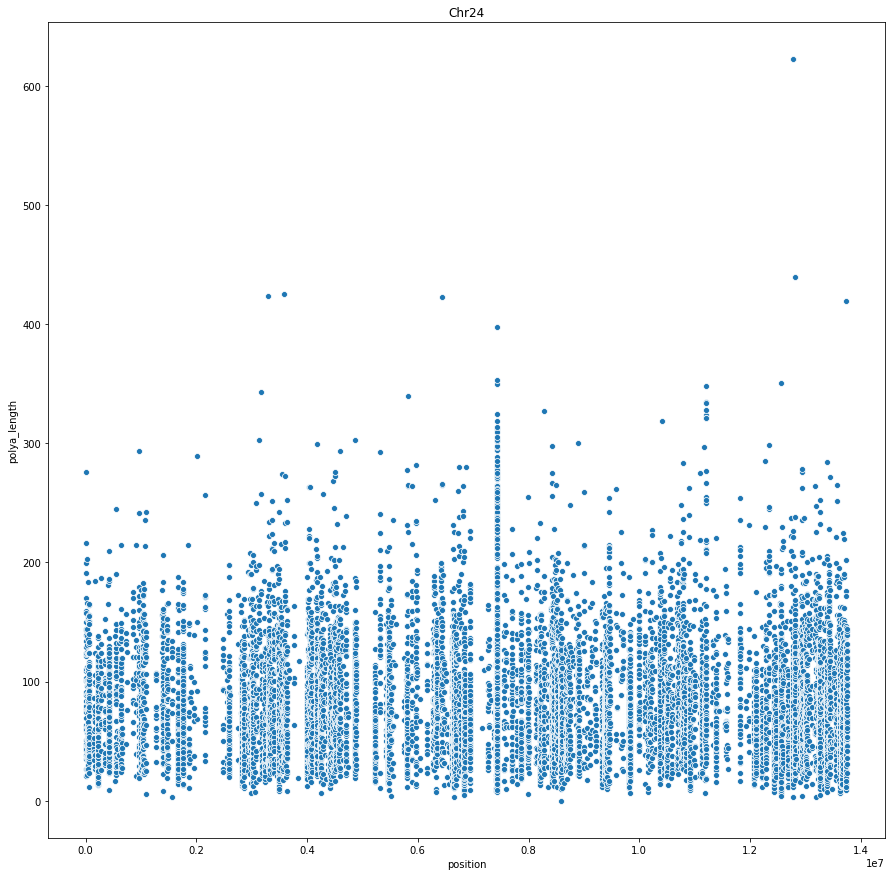

In [8]:
chr24 = df[df.contig == "Chr24"]
plt.figure(figsize=(15, 15))
plt.title("Chr24")
sns.scatterplot(x = chr24.position, y = chr24.polya_length)

All result files were labelled like this:
#### sed 's/PASS/PASS\tng/' polya_results_new_gam_pass.tsv > polya_results_new_gam_pass_lab.tsv
Then merged to one file:
#### cat *pass_lab.tsv > full_polya.tsv
#### cut -f 2,3,9,11 full_polya.tsv > full_cut_polya.tsv

In [9]:
full = pd.read_csv('full_cut_polya.tsv', sep="\t", header=None)
full.head()

,0,1,2,3
0,Chr01,9703,108.31,ng2
1,Chr01,10933,74.77,ng2
2,Chr01,9129,101.17,ng2
3,Chr01,10874,151.93,ng2
4,Chr01,9054,135.96,ng2


For further processing, the data frame should be sorted. To reset indexes just written and re-read the table.

In [12]:
full = full.rename(columns={0: "Chr", 1: "pos", 2: "leng", 3: "lab"})
full = full.sort_values(by=["Chr", "pos"])
full.head()

,Chr,pos,leng,lab
1600745,Chr01,8969,133.00,np
1600747,Chr01,8971,116.55,np
940205,Chr01,8973,63.77,ng
1600749,Chr01,9020,68.31,np
4,Chr01,9054,135.96,ng2


Here all reads with alignment position different less than 200 are labelled as the same feature.

In [17]:
coun = 0  # feature number
full = pd.read_csv('polya_sorted.tsv', sep="\t")
full["coun"] = None  # place for feature numbers
counts = np.array(full.coun)  
li = full.iloc[0]
for i, l in full.iterrows():
    if (l[0] == li[0]) and (abs(l[1] - li[1]) <= 200): # comparing two neighboring lines
                    counts[i] = coun
    else:
        coun += 1
        counts[i] = coun
        li = full.iloc[i]
full.coun = counts

In [18]:
full.head()

,Chr,pos,leng,lab,coun
0,Chr01,8969,133.00,np,0
1,Chr01,8971,116.55,np,0
2,Chr01,8973,63.77,ng,0
3,Chr01,9020,68.31,np,0
4,Chr01,9054,135.96,ng2,0


Making a label for grouping protonemata and gametophores. Then we can use statistics of different groups of the dataframe.

In [19]:
full["llab"] = full.lab.apply(lambda x: 1 if x.find("p") != -1 else 0)
common_stats = full.groupby([full.coun], as_index=False).agg({"pos": "mean", "leng":"describe", "Chr": "max"})
common_stats.head()

pos  leng                                                          \
            pos count        mean        std     min     25%     50%      75%   
0   9025.571429   7.0   96.712857  33.275010   58.23   66.04  101.17  124.775   
1   9203.000000   1.0   52.350000        NaN   52.35   52.35   52.35   52.350   
2   9703.000000   1.0  108.310000        NaN  108.31  108.31  108.31  108.310   
3  10903.500000   2.0  113.350000  54.560359   74.77   94.06  113.35  132.640   
4  12054.000000   1.0   60.170000        NaN   60.17   60.17   60.17   60.170   

             Chr  
      max    Chr  
0  135.96  Chr01  
1   52.35  Chr01  
2  108.31  Chr01  
3  151.93  Chr01  
4   60.17  Chr01

We can use only features with good coverage, but it does not change the whole picture a lot.

In [21]:
filt = common_stats[common_stats[("leng", "count")] > 4]
filt.shape

(46626, 10)

Text(0, 0.5, 'fraction')

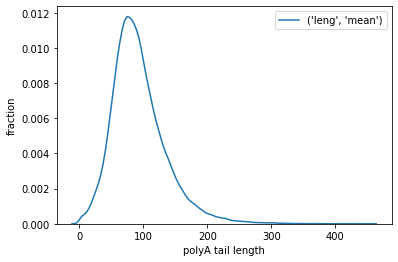

In [22]:
sns.kdeplot(common_stats[("leng", "mean")])
plt.xlabel("polyA tail length")
plt.ylabel("fraction")

Is there a correlation between the tail length and the number of reads?

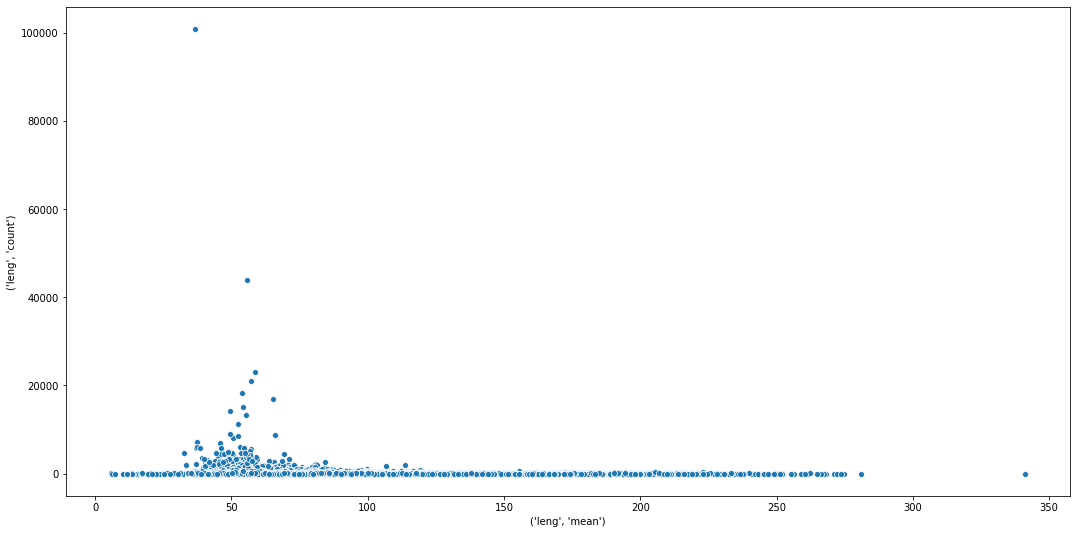

In [23]:
plt.rcParams['figure.figsize'] = (18, 9)

sns.scatterplot(x=filt[("leng", "mean")], y=filt[("leng", "count")])

Distribution of the number of reads.

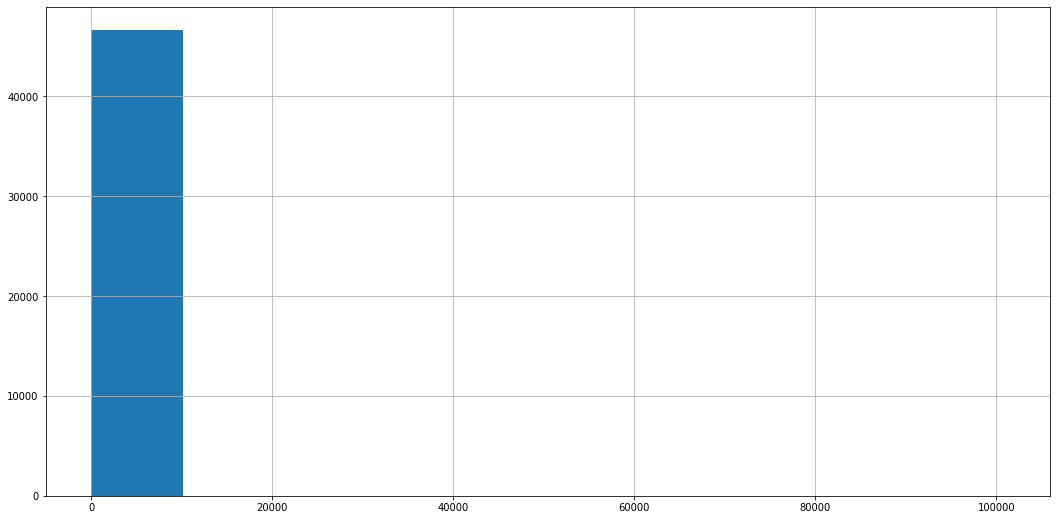

In [24]:
filt[("leng", "count")].hist()

Counting Spearman correlation. It is significant.

In [27]:
coef, p = spearmanr(filt[("leng", "mean")], filt[("leng", "count")])
print(coef, p)

-0.22205150489481926 0.0


Is there any difference in tail length between the same genes in protonemata and gametophores?

There are two features where Mann-Whitney test crashes. Remove them.

In [37]:
full = full[full.coun != 64216]
full = full[full.coun != 95615]

In [38]:
prot = []
gam = []
mw = pd.DataFrame(columns=['stat', 'p', 'coun'])
for name, group in full.groupby(full.coun):
    for row_index, row in group.iterrows():
        if row[5] == 1:   # taking prots and gams to different lists
            prot.append(row[2]) 
        else:
            gam.append(row[2]) 
    stat, p = mannwhitneyu(prot, gam)  # comparing the lists with Mann-Whitney
    mw.loc[name, 'stat'] = stat
    mw.loc[name, 'p'] = p
    mw.loc[name, 'coun'] = name
    prot.clear()
    gam.clear()

There are many features to rare to compare. Remove them.

In [39]:
mw = mw[mw.stat != 0]

There are multiple comparisons, so using a correction.

In [40]:
mw['aj_p'] = multipletests(mw.p, method='fdr_bh')[1]
sign = mw[mw["aj_p"] < 0.05]

We need to get genome positions of the significant features to get the gene names.

In [42]:
sign.head()

,stat,p,coun,aj_p
65,52183,1.41131e-06,65,0.000152765
69,6563.5,1.21005e-06,69,0.000134184
88,7,0.000604336,88,0.0269233
106,165090,2.67025e-06,106,0.000265775
107,38271,1.9338e-06,107,0.000200865


In [47]:
common_stats["coun"] = common_stats.index
con = sign.merge(common_stats, on="coun", how="left")
con = con[con.p > 0]
con.head()

/home/anna/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,stat,p,coun,aj_p,"(pos, pos)","(leng, count)","(leng, mean)","(leng, std)","(leng, min)","(leng, 25%)","(leng, 50%)","(leng, 75%)","(leng, max)","(Chr, Chr)"
0,52183,1.41131e-06,65,0.000152765,76062.507152,769.0,49.994642,25.127751,11.54,32.570,44.22,63.15,202.69,Chr01
1,6563.5,1.21005e-06,69,0.000134184,94237.337705,305.0,84.414328,46.595773,12.88,48.560,76.15,115.75,239.73,Chr01
2,7,0.000604336,88,0.0269233,187413.851852,27.0,71.145926,31.101513,26.62,50.825,64.76,86.08,146.93,Chr01
3,165090,2.67025e-06,106,0.000265775,218166.371298,1317.0,50.940706,26.695874,5.73,32.600,44.12,62.85,326.07,Chr01
4,38271,1.9338e-06,107,0.000200865,218389.649351,693.0,54.888773,28.193334,11.23,34.330,48.03,69.73,197.79,Chr01


Searching the nearest feature. The gap between the annotated and found features were not larger than 300 nucleotides.

In [ ]:
n = None  # gap between the feature and the annotation
batch = []
cool_gene = None  # we need just the gene list
with open("/home/anna/laba/polya_genes",'r') as b:
    with open('/home/anna/laba/Ppatens_318_v3.3.gene.gff3', 'r') as annot:
        for read in b:
            list_read = read.split(',')
            for i in annot:
                list_annot = i.split('\t')
                if list_read[1].strip() == list_annot[0]:
                    if n == None:
                        n = float(list_read[0]) - int(list_annot[3])
                        cool_gene = list_annot[8]
                    else:
                        if abs(float(list_read[0]) - int(list_annot[3])) < abs(n):
                            n = float(list_read[0]) - int(list_annot[3])
                            cool_gene = list_annot[8]
            batch.append(str(n))
            batch.append(cool_gene)
            n = None
            annot.seek(0)
with open("/home/anna/laba/genes_polya_names", "w") as positive:
    positive.write("".join(batch))

Then using **go_search.py** script and looking at the results.

In [54]:
genes = pd.read_csv('polya_sig_go.tsv', sep='\t', header=None)
genes.head()

,0,1,2,3,4,5,6,7
0,Pp3c1_120,PAC:32969574 2142,75317,77458,GO:0003735,structural constituent of ribosome,The action of a molecule that contributes to t...,(1 of 7) K02891 - large subunit ribosomal prot...
1,Pp3c1_120,PAC:32969574 2142,75317,77458,GO:0005622,intracellular,The living contents of a cell; the matter cont...,(1 of 7) K02891 - large subunit ribosomal prot...
2,Pp3c1_120,PAC:32969574 2142,75317,77458,GO:0005840,ribosome,"An intracellular organelle, about 200 A in dia...",(1 of 7) K02891 - large subunit ribosomal prot...
3,Pp3c1_120,PAC:32969574 2142,75317,77458,GO:0006412,translation,The cellular metabolic process in which a prot...,(1 of 7) K02891 - large subunit ribosomal prot...
4,Pp3c1_420,PAC:32969476 2034,217470,219503,GO:0003735,structural constituent of ribosome,The action of a molecule that contributes to t...,(1 of 4) K02983 - small subunit ribosomal prot...


In [55]:
counts = genes.iloc[:, 4].groupby(genes.iloc[:,5]).count()
counts.sort_values()

5
mitochondrial outer membrane                                                                 1
inositol-1,3,4-trisphosphate 6-kinase activity                                               1
inositol-1,3,4-trisphosphate 5-kinase activity                                               1
inositol trisphosphate metabolic process                                                     1
inositol tetrakisphosphate 1-kinase activity                                                 1
hydroxyacylglutathione hydrolase activity                                                    1
protein transport                                                                            1
protein-L-isoaspartate (D-aspartate) O-methyltransferase activity                            1
hydro-lyase activity                                                                         1
heat shock protein binding                                                                   1
glycyl-tRNA aminoacylation                      